Performed Exploratory data analysis on a marketing dataset to get interesting insights from the data and to suggest ways to improve the marketing campaigns using statistical analysis. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data sets/marketing_data.csv')

In [4]:
df.head()
print((df.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [5]:
# clean up column names that contain whitespace
df.columns = df.columns.str.replace(' ', '')

# transform Income column to a numerical
df['Income'] = df['Income'].str.replace('$', '')
df['Income'] = df['Income'].str.replace(',', '').astype('float')

In [6]:
# null values
df.isnull().sum().sort_values(ascending=False)

Income                 24
Country                 0
Complain                0
Year_Birth              0
Education               0
Marital_Status          0
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
ID                      0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


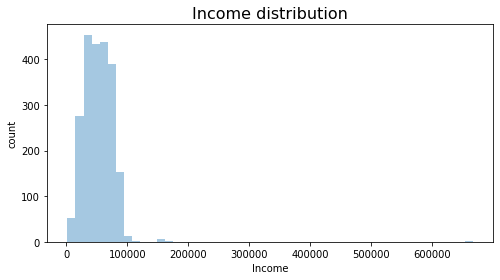

In [7]:
plt.figure(figsize=(8,4))
sns.distplot(df['Income'], kde=False, hist=True)
plt.title('Income distribution', size=16)
plt.ylabel('count');

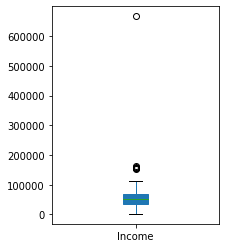

In [8]:
#make a box plot
df['Income'].plot(kind='box', figsize=(3,4), patch_artist=True)

After plotting the income distrubtion, we observe that there are 24 outliers and we can replace them with the median to avoid skewing of the mean

In [9]:
income_median = df['Income'].median()
#print(income_median)
df['Income'] = df['Income'].fillna(income_median)
#df['Income'] = df['Income'].fillna(df['Income'].median())


To check which columns have outliers and how to wrangle them.
We can see that in yeat of birth , there are outliers where year is less than 1900, we can omit them in this case.

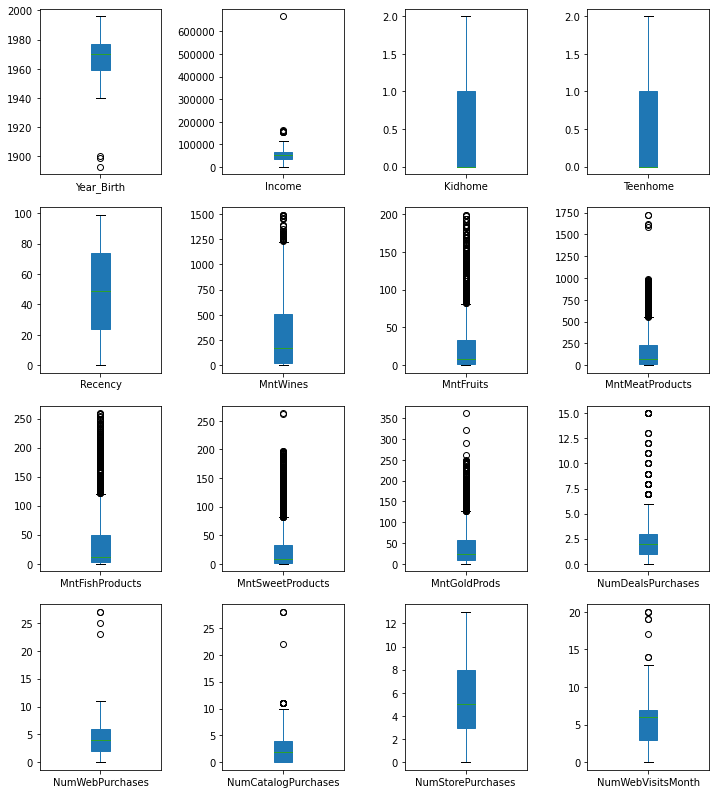

In [10]:
# select columns to plot
df_to_plot = df.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']).select_dtypes(include=np.number)

# subplots
df_to_plot.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

Converting the date to date_time format for better modeling


In [11]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])


Performing some feature engineering so that we can reduce the number of columns to some useful features.

In [12]:
# Dependents
df['Dependents'] = df['Kidhome'] + df['Teenhome']

# Year becoming a Customer
df['Year_Customer'] = pd.DatetimeIndex(df['Dt_Customer']).year

# Total Amount Spent
mnt_cols = []
for col in df.columns:
    if 'Mnt' in col:
        mnt_cols.append(col)
#mnt_cols = [col for col in df.columns if 'Mnt' in col]
df['TotalMnt'] = df[mnt_cols].sum(axis=1)

# Total Purchases
purchases_cols = [col for col in df.columns if 'Purchases' in col]
df['TotalPurchases'] = df[purchases_cols].sum(axis=1)

# Total Campaigns Accepted
campaigns_cols = [col for col in df.columns if 'Cmp' in col] + ['Response'] # 'Response' is for the latest campaign
df['TotalCampaignsAcc'] = df[campaigns_cols].sum(axis=1)

# view new features, by customer ID
df[['ID', 'Dependents', 'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc']].head()


,ID,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc
0,1826,0,2014,1190,15,1
1,1,0,2014,577,18,2
2,10476,1,2014,251,11,0
3,1386,2,2014,11,4,0
4,5371,1,2014,91,8,2


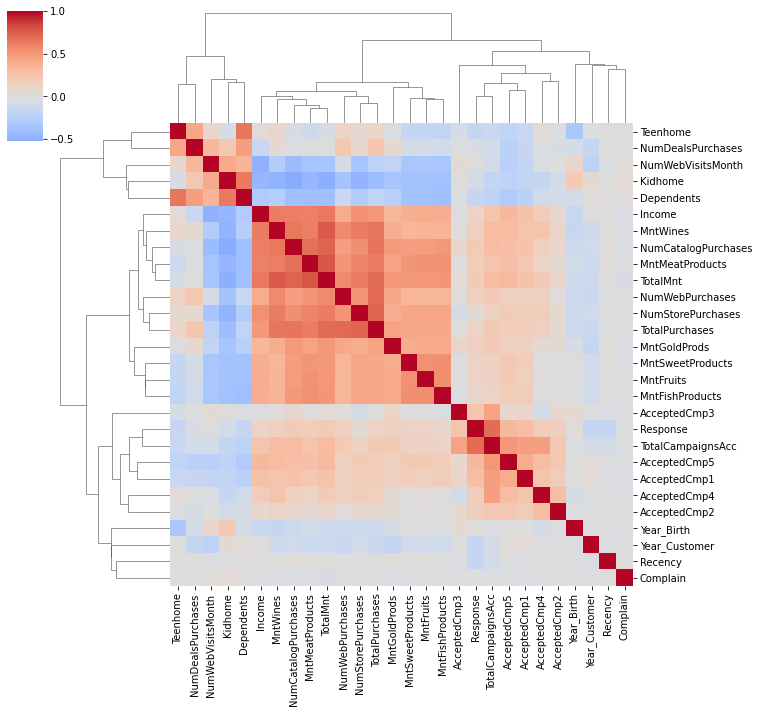

In [13]:
# calculate correlation matrix
## using non-parametric test of correlation (kendall), since some features are binary
corrs = df.drop(columns='ID').select_dtypes(include=np.number).corr(method = 'kendall')

# plot clustered heatmap of correlations
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0);



From the heat map we can see that the total amount spent is directly proportional to Income. We are plotting to see that relation below .

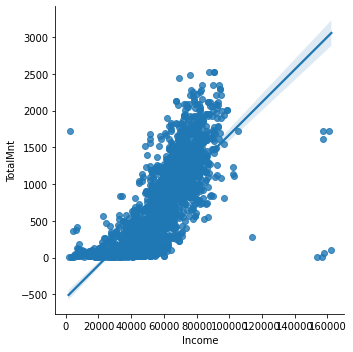

In [14]:
sns.lmplot(x='Income', y='TotalMnt', data=df[df['Income'] < 200000]);


As number of dependants increases (kids and teens at home), the total amount spent decreases


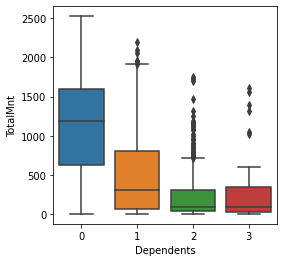

In [15]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='TotalMnt', data=df);


Plot illustrating positive effect of having dependents (kids & teens) on number of deals purchased

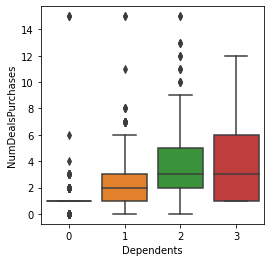

In [16]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='NumDealsPurchases', data=df);

Plots illustrating the positive effect of income and negative effect of having kids & teens on advertising campaign acceptance

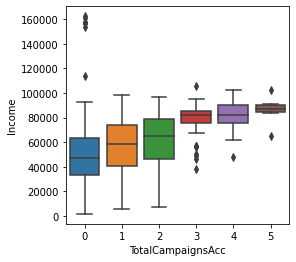

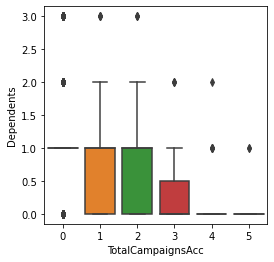

In [17]:
plt.figure(figsize=(4,4))
sns.boxplot(x='TotalCampaignsAcc', y='Income', data=df[df['Income']<200000]); 
plt.figure(figsize=(4,4))
sns.boxplot(x='TotalCampaignsAcc', y='Dependents', data=df); 

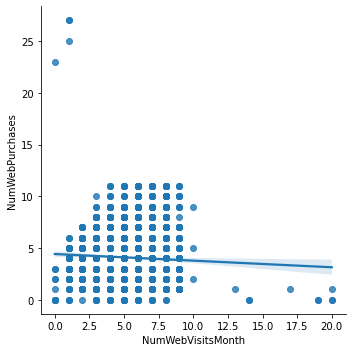

In [18]:
sns.lmplot(x='NumWebVisitsMonth', y='NumWebPurchases', data=df);


Anomaly- Number of web visits is not positively correlated with number of web purchases.  Instead it is positively correlated with number of deals purchases. showing the importance of deals.

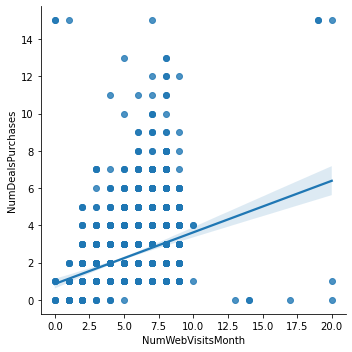

In [19]:

sns.lmplot(x='NumWebVisitsMonth', y='NumDealsPurchases', data=df);


In order to know about the factors that affect Number of store purchases, we can fit a linear regression model to it and calculate feature importance.**bold text**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


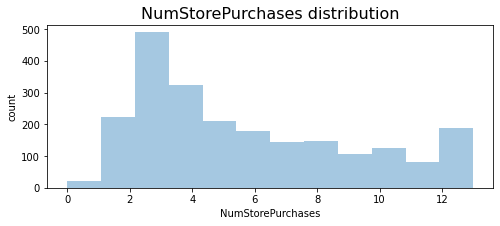

In [20]:
plt.figure(figsize=(8,3))
sns.distplot(df['NumStorePurchases'], kde=False, hist=True, bins=12)
plt.title('NumStorePurchases distribution', size=16)
plt.ylabel('count');

In [21]:
# drop unique ID
df.drop(columns=['ID', 'Dt_Customer'], inplace=True)

In [22]:
# one-hot encoding of categorical features
from sklearn.preprocessing import OneHotEncoder

# get categorical features and review number of unique values
cat = df.select_dtypes(exclude=np.number)
print("Number of unique values per categorical feature:\n", cat.nunique())

# use one hot encoder
enc = OneHotEncoder(sparse=False).fit(cat)
cat_encoded = pd.DataFrame(enc.transform(cat))
cat_encoded.columns = enc.get_feature_names(cat.columns)

# merge with numeric data
num = df.drop(columns=cat.columns)
df2 = pd.concat([cat_encoded, num], axis=1)
df2.head()

Number of unique values per categorical feature:
 Education         5
Marital_Status    8
Country           8
dtype: int64


,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Country_AUS,Country_CA,Country_GER,Country_IND,Country_ME,Country_SA,Country_SP,Country_US,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1970,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,0,2014,1190,15,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1961,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,0,2014,577,18,2
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1958,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,1,2014,251,11,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1967,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,2,2014,11,4,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1989,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,1,2014,91,8,2


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# isolate X and y variables, and perform train-test split
X = df2.drop(columns='NumStorePurchases')
y = df2['NumStorePurchases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
preds = model.predict(X_test)

# evaluate model using RMSE
print("Linear regression model RMSE: ", np.sqrt(mean_squared_error(y_test, preds)))
print("Median value of target variable: ", y.median())

Linear regression model RMSE:  4.8514961620221064e-14
Median value of target variable:  5.0


In [26]:
%pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=5)

     |████████████████████████████████| 106 kB 5.3 MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


After calculating feature importance we realise that only 'TotalPurchases', 'NumCatalogPurchases', 'NumWebPurchases', 'NumDealsPurchases' are affecting the num of store purchases. Rest of them are not important.

**Answering and finding relations among different features to answer some interesting questions.**

Observation -Spain has the highest amount on purchases

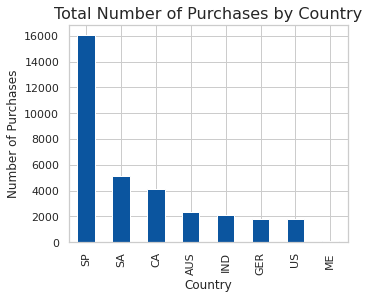

In [ ]:
plt.figure(figsize=(5,4))
df.groupby('Country')['TotalPurchases'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Number of Purchases by Country', size=16)
plt.ylabel('Number of Purchases');

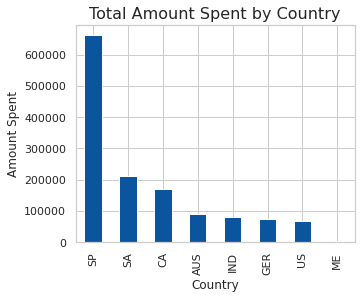

In [ ]:
plt.figure(figsize=(5,4))
df.groupby('Country')['TotalMnt'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Amount Spent by Country', size=16)
plt.ylabel('Amount Spent');

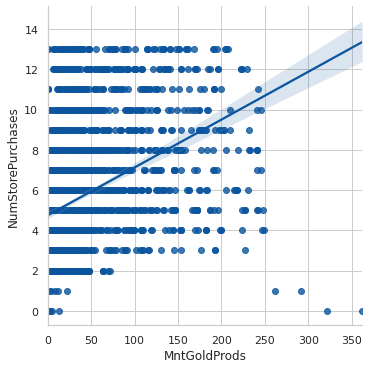

In [ ]:
sns.lmplot(x='MntGoldProds', y='NumStorePurchases', data = df);


We can observe that customers who spend on gold are also more likely to do in store purchasing. We can also confirm this by running a correlation test. 
The result from the test shows that gold purchases is indeed positvely related with instore purchasing. Since the p-value associated with the test is very less we can easily accept this result.

In [ ]:
from scipy.stats import kendalltau

kendall_corr = kendalltau(x=df['MntGoldProds'], y=df['NumStorePurchases'])

# print results
print('Kendall correlation (tau): ', kendall_corr.correlation)
print('Kendall p-value: ', kendall_corr.pvalue)

Kendall correlation (tau):  0.39229092816306144
Kendall p-value:  4.752746314649227e-152


We want to know which campaign has been the most successful regionally, we find this out by calculating logistic regression p-values for the respective campaigns.
We can conclude that the regional effects on the campaigns are statistically significant.

In [ ]:
# calculate logistic regression p-values for campaign acceptance ~ country using generalized linear model
import statsmodels.formula.api as smf
import statsmodels as sm
from scipy import stats

## get the data of interest for glm
df_cam_wide = df[['Country', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]

## to store statistics results
stat_results = []

## perform glm
for col in df_cam_wide.drop(columns='Country').columns:
    this_data = df_cam_wide[['Country', col]]
    
    # define formula
    formula = col+'~Country'
    
    # logistic regression (family=binomial)
    model = smf.glm(formula = formula, data=this_data, family=sm.genmod.families.Binomial())
    result = model.fit()
    
    # get chisquare value for overall model (CampaignAccepted ~ Country) and calculate p-value
    chisq = result.pearson_chi2
    pval = stats.distributions.chi2.sf(chisq , 7) # Df Model = 7 degrees of freedom when you run result.summary()
     
    # append to stat_results
    stat_results.append(pval)
    
    # print stat summary for entire model
    print(result.summary())
    
## check results
print("\nChisq p-values: ", stat_results)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                 Generalized Linear Model Regression Results                  
Dep. Variable:           AcceptedCmp1   No. Observations:                 2240
Model:                            GLM   Df Residuals:                     2232
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -532.70
Date:                Thu, 08 Jul 2021   Deviance:                       1065.4
Time:                        20:23:05   Pearson chi2:                 2.24e+03
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0845      0.387     -7.

After plotting the advertising campaigns with respscts to their successes we can see that the latest campaign (response) has been the most effective in terms of acceptance by customers.

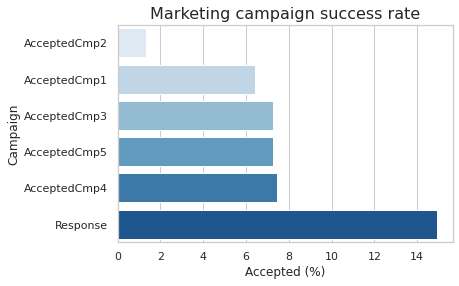

In [ ]:
# calculate success rate (percent accepted)
cam_success = pd.DataFrame(df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].mean()*100, 
                           columns=['Percent']).reset_index()
#print(cam_success)
# plot
sns.barplot(x='Percent', y='index', data=cam_success.sort_values('Percent'), palette='Blues')
plt.xlabel('Accepted (%)')
plt.ylabel('Campaign')
plt.title('Marketing campaign success rate', size=16);

In [ ]:
# list of cols with binary responses
binary_cols = [col for col in df.columns if 'Accepted' in col] + ['Response', 'Complain']
#print(binary_cols)
# list of cols for spending 
mnt_cols = [col for col in df.columns if 'Mnt' in col]
print(mnt_cols)
# list of cols for channels
channel_cols = [col for col in df.columns if 'Num' in col] + ['TotalPurchases', 'TotalCampaignsAcc']
#channel_cols

['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'TotalMnt']


The report of an average customer for the company: 

In [ ]:
demographics = pd.DataFrame(round(df.drop(columns=binary_cols+mnt_cols+channel_cols).mean(), 1), columns=['Average']).reindex([
    'Year_Birth', 'Year_Customer', 'Income', 'Dependents', 'Kidhome', 'Teenhome', 'Recency'])

In [ ]:
demographics

,Average
Year_Birth,1968.8
Year_Customer,2013.0
Income,52238.0
Dependents,1.0
Kidhome,0.4
Teenhome,0.5
Recency,49.1


The best performing products are wines and meat.
Fruits and sweets are the least performing products. 
Maybe the marketing strategy should be to increase the sales of fruits and sweets while also capitalising customer interests in buying wine and meat.

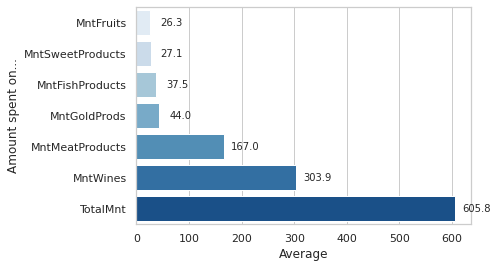

In [ ]:
spending = pd.DataFrame(round(df[mnt_cols].mean(), 1), columns=['Average']).sort_values(by='Average').reset_index()

# plot
ax = sns.barplot(x='Average', y='index', data=spending, palette='Blues')
plt.ylabel('Amount spent on...')

## add text labels for each bar's value
for p,q in zip(ax.patches, spending['Average']):
    ax.text(x=q+40,
            y=p.get_y()+0.5,
            s=q,
            ha="center") ;

Advertising campaign is the least performing marketing strategy, maybe the company must decide on changing the ad agency, as expected store purchases is the most chosen way of shopping.

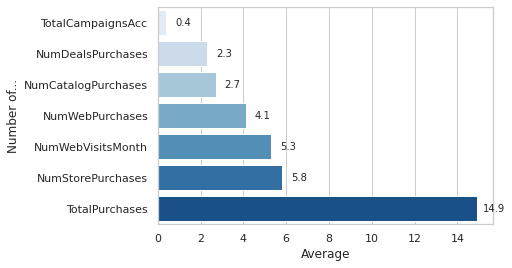

In [ ]:
channels = pd.DataFrame(round(df[channel_cols].mean(), 1), columns=['Average']).sort_values(by='Average').reset_index()

# plot
ax = sns.barplot(x='Average', y='index', data=channels, palette='Blues')
plt.ylabel('Number of...')

## add text labels for each bar's value
for p,q in zip(ax.patches, channels['Average']):
    ax.text(x=q+0.8,
            y=p.get_y()+0.5,
            s=q,
            ha="center") ;

**We can conclude by giving out a few suggestions :**
1. The recent advertising campaign was most effective, company should delve deep and understand how this campaign is different from previous ones and improve on it.
2.Advertising campaign acceptance is positively correlated with income and negatively correlated with having kids/teen. 
The campaign should be made taking into consideration both categories of people.
3. Wine and Meat are the most popular products purchased, company should focus on least performing products.
4. Store purchases are the most popular way of shopping, marketing campaign should focus on emphasizing on this.